# Personalised Cancer Diagnosis

### 1. Business Problem

##### Description
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ 
Data: Memorial Sloan Kettering Cancer Center (MSKCC)
Download training_variants.zip and training_text.zip from Kaggle. 

Context:
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

Problem statement : 
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

### 2. Business Constraints

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

### 3.1 Type of Machine learning problem
 
There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
### 3.2 Performance Metric

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

*Multi class log loss

*Confusion Matrix

## Exploratory Data Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier


from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 

from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")



from sklearn import model_selection
from sklearn.linear_model import LogisticRegression



C:\Users\Niccos Nayak\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Niccos Nayak\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 3.1 Reading data

In [4]:
# Reading the variants data
df = pd.read_csv('D:\\AAI\\Case study Cancer diagnosis\\training_variants\\training_variants')

In [10]:
print('The number of data points are ',df.shape[0])
print('The total number of features are ',df.shape[1])
print('Feature names ',df.columns.values)

The number of data points are  3321
The total number of features are  4
Feature names  ['ID' 'Gene' 'Variation' 'Class']


In [13]:
#Reading the text data

df_text = pd.read_csv('D:\\AAI\\Case study Cancer diagnosis\\training_text\\training_text', sep ='\|\|' , engine ='python', names = ['ID','TEXT'],skiprows = 1)

In [17]:
print("the number of data points are", df_text.shape[0])
print("the number of features are", df_text.shape[1])
print("feature names:", df_text.columns.values)

the number of data points are 3321
the number of features are 2
feature names: ['ID' 'TEXT']


In [24]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        df_text[column][index] = string

### 3.1.1 Preprocessing data

In [27]:
# Preprocessing stage

start_time = time.clock()

for index,row in df_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row["TEXT"],index,"TEXT")
    else:
        print("Text with no text description: ",index)
        
print("Time taken for prepocessing: ",time.clock()-start_time,"seconds")    


Text with no text description:  1109
Text with no text description:  1277
Text with no text description:  1407
Text with no text description:  1639
Text with no text description:  2755
Time taken for prepocessing:  247.5417959567112 seconds


In [40]:
#merge the variants data and the text data

result = pd.merge(df,df_text, on ="ID", how ="left")
result.head(3)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...


In [41]:
# replace the null values in  TeXT with its gene and variation

result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [46]:
result.loc[result["TEXT"].isnull(),"TEXT"] = result["Gene"] +' '+result["Variation"]

In [47]:
result[result["ID"]==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


### 3.1.3 Test, Train and Cross-Validation Split

In [49]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

### Distribution of y_i's in Train,Test and CV datasets

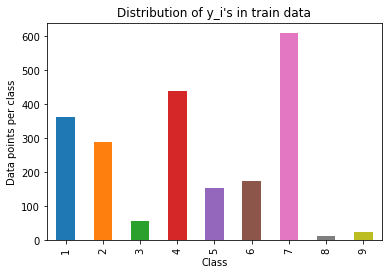

Number of data points in class  7 : 609 ( 28.672  )
Number of data points in class  4 : 439 ( 20.669  )
Number of data points in class  1 : 363 ( 17.09  )
Number of data points in class  2 : 289 ( 13.606  )
Number of data points in class  6 : 176 ( 8.286  )
Number of data points in class  5 : 155 ( 7.298  )
Number of data points in class  3 : 57 ( 2.684  )
Number of data points in class  9 : 24 ( 1.13  )
Number of data points in class  8 : 12 ( 0.565  )


In [77]:
#counts of classes in train,test,cv
train_class_distribution = X_train["Class"].value_counts().sortlevel()
test_class_distribution = X_test["Class"].value_counts().sortlevel()
cv_class_distribution = X_cv["Class"].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind ="bar")
plt.xlabel("Class")
plt.ylabel("Data points per class")
plt.title("Distribution of y_i's in train data")
plt.grid
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)

for i in sorted_yi:
    print("Number of data points in class ",i+1,":",train_class_distribution.values[i], "(" ,round(train_class_distribution.values[i]/X_train.shape[0]*100,3)," )")


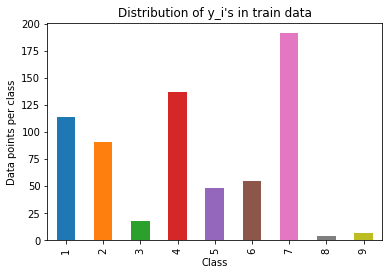

Number of data points in class  7 : 191 ( 28.722  )
Number of data points in class  4 : 137 ( 20.602  )
Number of data points in class  1 : 114 ( 17.143  )
Number of data points in class  2 : 91 ( 13.684  )
Number of data points in class  6 : 55 ( 8.271  )
Number of data points in class  5 : 48 ( 7.218  )
Number of data points in class  3 : 18 ( 2.707  )
Number of data points in class  9 : 7 ( 1.053  )
Number of data points in class  8 : 4 ( 0.602  )


In [58]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind ="bar")
plt.xlabel("Class")
plt.ylabel("Data points per class")
plt.title("Distribution of y_i's in test data")
plt.grid
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)

for i in sorted_yi:
    print("Number of data points in class ",i+1,":",test_class_distribution.values[i], "(" ,round(test_class_distribution.values[i]/X_test.shape[0]*100,3)," )")


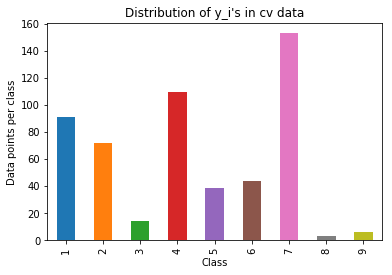

Number of data points in class  7 : 153 ( 28.759  )
Number of data points in class  4 : 110 ( 20.677  )
Number of data points in class  1 : 91 ( 17.105  )
Number of data points in class  2 : 72 ( 13.534  )
Number of data points in class  6 : 44 ( 8.271  )
Number of data points in class  5 : 39 ( 7.331  )
Number of data points in class  3 : 14 ( 2.632  )
Number of data points in class  9 : 6 ( 1.128  )
Number of data points in class  8 : 3 ( 0.564  )


In [59]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind ="bar")
plt.xlabel("Class")
plt.ylabel("Data points per class")
plt.title("Distribution of y_i's in cv data")
plt.grid
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)

for i in sorted_yi:
    print("Number of data points in class ",i+1,":",cv_class_distribution.values[i], "(" ,round(cv_class_distribution.values[i]/X_cv.shape[0]*100,3)," )")


## 3.2 Prediction using random model

In [60]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4748846008923495
Log loss on Test Data using Random Model 2.510181657683465
-------------------- Confusion matrix --------------------


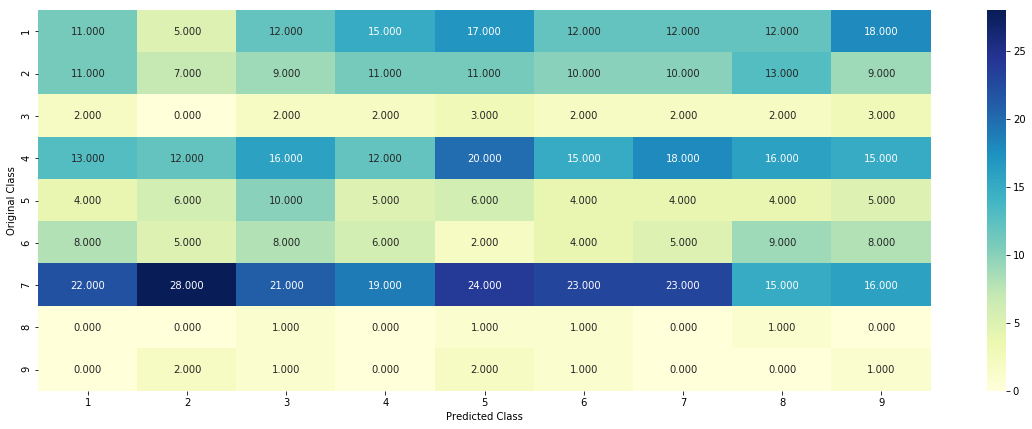

-------------------- Precision matrix (Columm Sum=1) --------------------


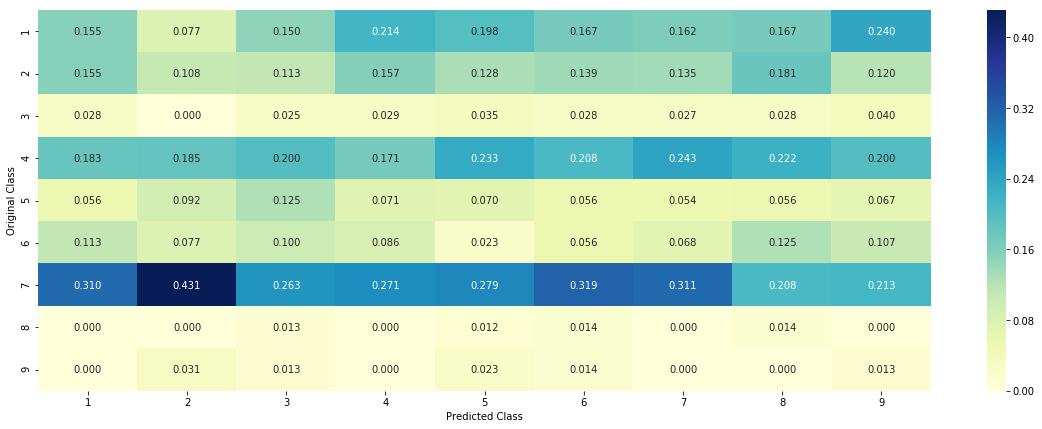

-------------------- Recall matrix (Row sum=1) --------------------


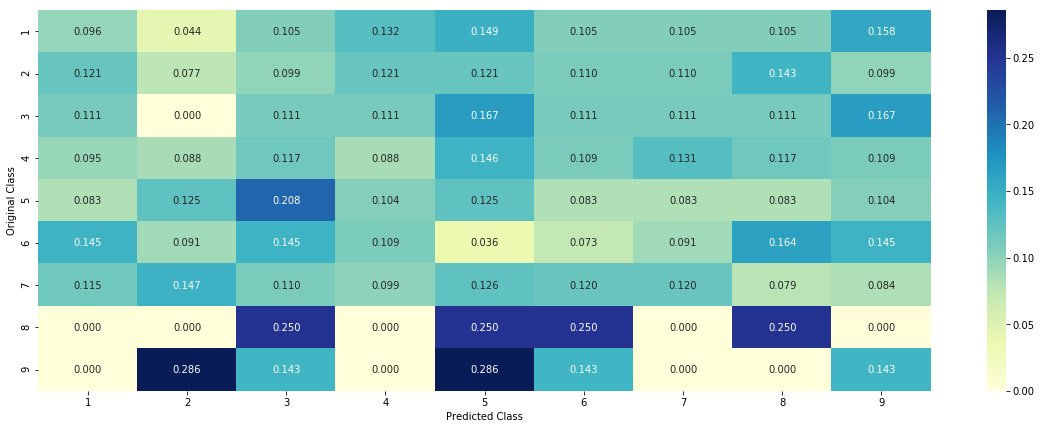

In [61]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## Univariate Analysis

In [87]:

# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
   
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):


            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []

    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea


### Univariate analysis on Gene feature



In [88]:
unique_genes = X_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 239
BRCA1     170
TP53      102
PTEN       83
EGFR       82
BRCA2      81
BRAF       65
KIT        57
ALK        45
ERBB2      44
PDGFRA     40
Name: Gene, dtype: int64


In [76]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 239 different categories of genes in the train data, and they are distibuted as follows


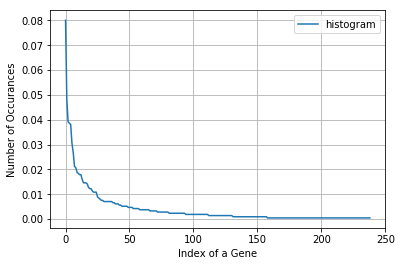

In [83]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label ="histogram")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

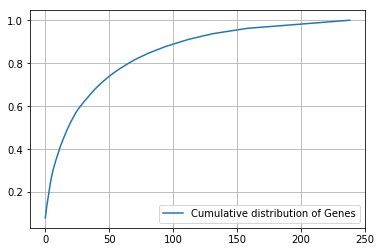

In [84]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [89]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_cv))

In [90]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [91]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])

In [92]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hra

In [93]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 238)


### How good is the gene feature in predicting the y_i by using machine learning models

We build a logistic Regression model on Gene feature(one hot encoded) to predict y_i.

For all values of alpha =  1e-05  log loss is  1.4179059320122935
For all values of alpha =  0.0001  log loss is  1.2631339864586681
For all values of alpha =  0.001  log loss is  1.2983415000042315
For all values of alpha =  0.01  log loss is  1.4028794891544896
For all values of alpha =  0.1  log loss is  1.463505046954569
For all values of alpha =  1  log loss is  1.492150611508267


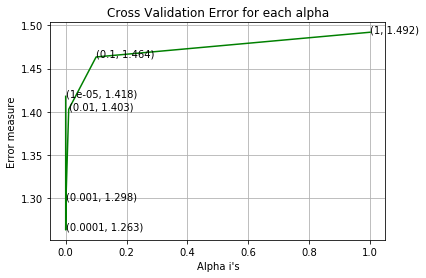

For values of best alpha =  0.0001 The train log loss is: 1.0168372822125404
For values of best alpha =  0.0001 The cross validation log loss is: 1.2631339864586681
For values of best alpha =  0.0001 The test log loss is: 1.2021491444124308


In [104]:
#list of the alphas
alpha = [10**x for x in range(-5,1)]

cv_log_error_array =[]
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty = "l2", loss ="log", random_state =42)
    clf.fit(train_gene_feature_onehotCoding,y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding,y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels = clf.classes_,eps = 1e-15))
    
    print("For all values of alpha = ",i ," log loss is ",log_loss(y_cv,predict_y, labels = clf.classes_,eps = 1e-15))
    
fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error_array,c ="g")
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty ="l2", loss ="log",random_state = 42)
clf.fit(train_gene_feature_onehotCoding,y_train)

sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding,y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Univariate analysis of variation feature

In [108]:
unique_variation = X_train["Variation"].value_counts()
print("The number of unique Variations are ",unique_variation.shape[0])

The number of unique Variations are  1934


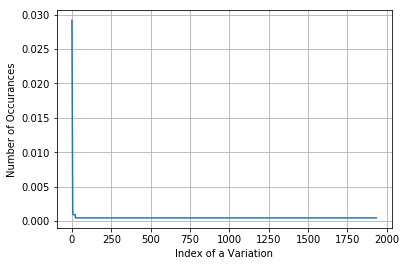

In [115]:
s = sum(unique_variation.values)
h = unique_variation.values/s
plt.plot(h,label = "histogram")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.grid()
plt.show()

[0.02919021 0.05225989 0.07156309 ... 0.99905838 0.99952919 1.        ]


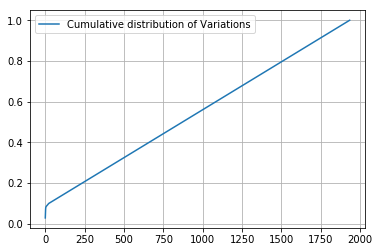

In [116]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [118]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_train))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_test))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_cv))

In [119]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [120]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])

print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1971)


### How good is variation feature while predicting y_is using machine learning model

In [ ]:
#Used logistic Regression with callibration

For values of alpha =  1e-05 The log loss is: 1.6959569681304685
For values of alpha =  0.0001 The log loss is: 1.6856453304660013
For values of alpha =  0.001 The log loss is: 1.696968810119765
For values of alpha =  0.01 The log loss is: 1.7153682364999305
For values of alpha =  0.1 The log loss is: 1.726083261297928
For values of alpha =  1 The log loss is: 1.7266191923695353


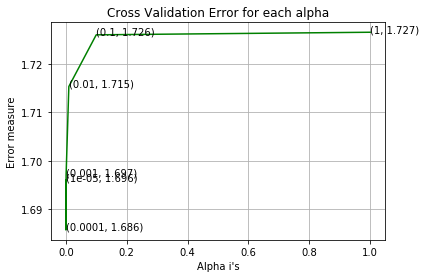

For values of best alpha =  0.0001 The train log loss is: 0.7276099700562647
For values of best alpha =  0.0001 The cross validation log loss is: 1.6856453304660013
For values of best alpha =  0.0001 The test log loss is: 1.7125770189903209


In [122]:
alpha = [10 ** x for x in range(-5, 1)]




cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [ ]:
# Check whether variation feature is good enough

### Univariate analysis on TEXT feature

In [153]:
from collections import Counter, defaultdict
# Unique qords in TEXT feature
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [154]:
#response coding

import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [155]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53621


In [157]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [158]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_cv)

In [159]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [178]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [179]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [180]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5125, 4: 4019, 5: 3194, 6: 2608, 8: 2200, 7: 1893, 11: 1809, 9: 1556, 10: 1340, 12: 1301, 14: 949, 13: 878, 15: 798, 16: 739, 20: 653, 24: 616, 18: 615, 22: 574, 17: 532, 21: 524, 19: 520, 25: 404, 23: 373, 27: 354, 30: 351, 28: 350, 26: 349, 42: 341, 35: 303, 29: 279, 54: 276, 33: 263, 32: 261, 40: 258, 31: 249, 34: 248, 36: 236, 37: 201, 48: 194, 38: 192, 39: 187, 43: 182, 47: 178, 45: 176, 44: 173, 49: 157, 55: 156, 46: 156, 41: 155, 56: 154, 51: 152, 50: 150, 52: 147, 57: 146, 53: 141, 60: 128, 59: 128, 64: 113, 58: 113, 72: 112, 65: 112, 70: 111, 62: 108, 66: 105, 86: 102, 67: 101, 61: 99, 68: 97, 63: 93, 76: 91, 71: 87, 88: 85, 80: 84, 73: 83, 69: 80, 81: 79, 84: 77, 79: 77, 83: 76, 75: 76, 77: 74, 78: 71, 89: 70, 74: 68, 101: 65, 90: 63, 108: 62, 104: 62, 100: 62, 92: 62, 91: 62, 96: 60, 93: 60, 117: 59, 109: 59, 97: 58, 87: 58, 98: 57, 111: 56, 103: 56, 95: 56, 85: 56, 82: 54, 110: 52, 94: 51, 128: 49, 133: 48, 129: 48, 114: 47, 130: 46, 120: 46, 113: 46, 112: 46, 9

For values of alpha =  1e-05 The log loss is: 1.4266526167931124
For values of alpha =  0.0001 The log loss is: 1.395840088226813
For values of alpha =  0.001 The log loss is: 1.3374687678065658
For values of alpha =  0.01 The log loss is: 1.3908807366576483
For values of alpha =  0.1 The log loss is: 1.4831136757231043
For values of alpha =  1 The log loss is: 1.6513826655941404


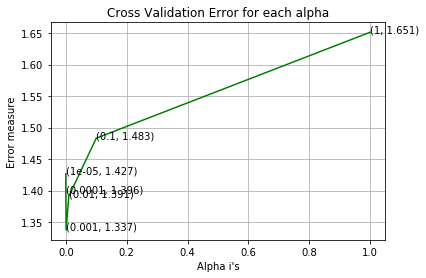

For values of best alpha =  0.001 The train log loss is: 0.7126914153001219
For values of best alpha =  0.001 The cross validation log loss is: 1.3374687678065658
For values of best alpha =  0.001 The test log loss is: 1.209974336054287


In [181]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]





cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



In [182]:
# To check the stability of the TEXT feature

def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [183]:
len1,len2 = get_intersec_text(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.321 % of word of test data appeared in train data
99.761 % of word of Cross Validation appeared in train data


## Machine Learning Model

In [184]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [185]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [186]:
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Stacking the three types of features

In [187]:
# merging gene,variation and text feature

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(X_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [189]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55830)
(number of data points * number of features) in test data =  (665, 55830)
(number of data points * number of features) in cross validation data = (532, 55830)


In [190]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Baseline models
### 1. Naive Bayes model

for alpha = 1e-05
Log Loss : 1.334549048467048
for alpha = 0.0001
Log Loss : 1.3377861955822454
for alpha = 0.001
Log Loss : 1.3385331748500442
for alpha = 0.1
Log Loss : 1.3357199498761787
for alpha = 1
Log Loss : 1.347390234790249
for alpha = 10
Log Loss : 1.456132909553172
for alpha = 100
Log Loss : 1.4783149821694876
for alpha = 1000
Log Loss : 1.4315814138765326


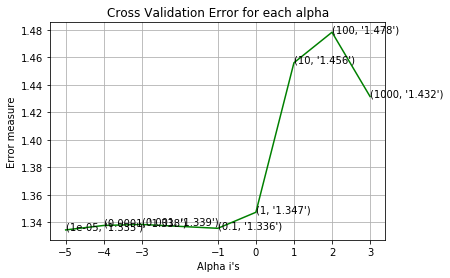

For values of best alpha =  1e-05 The train log loss is: 0.8111711154069569
For values of best alpha =  1e-05 The cross validation log loss is: 1.334549048467048
For values of best alpha =  1e-05 The test log loss is: 1.3283943624465073


In [191]:

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.334549048467048
Number of missclassified point : 0.41353383458646614
-------------------- Confusion matrix --------------------


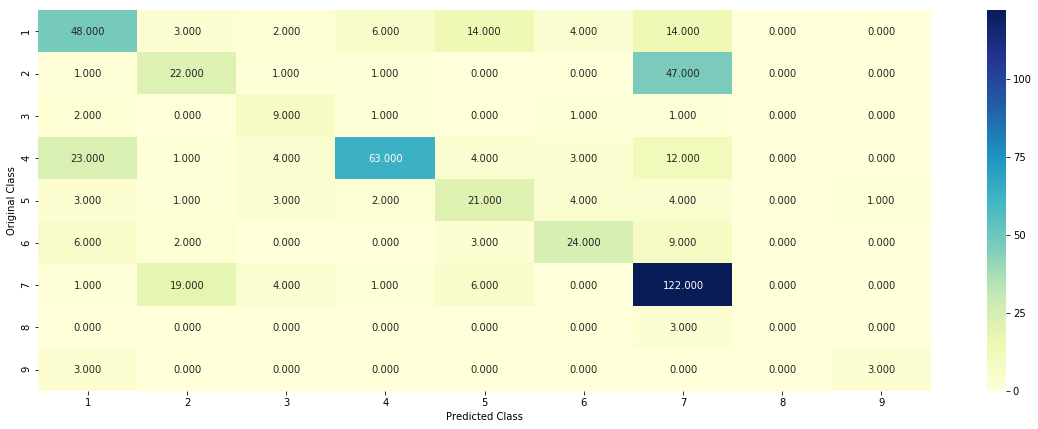

-------------------- Precision matrix (Columm Sum=1) --------------------


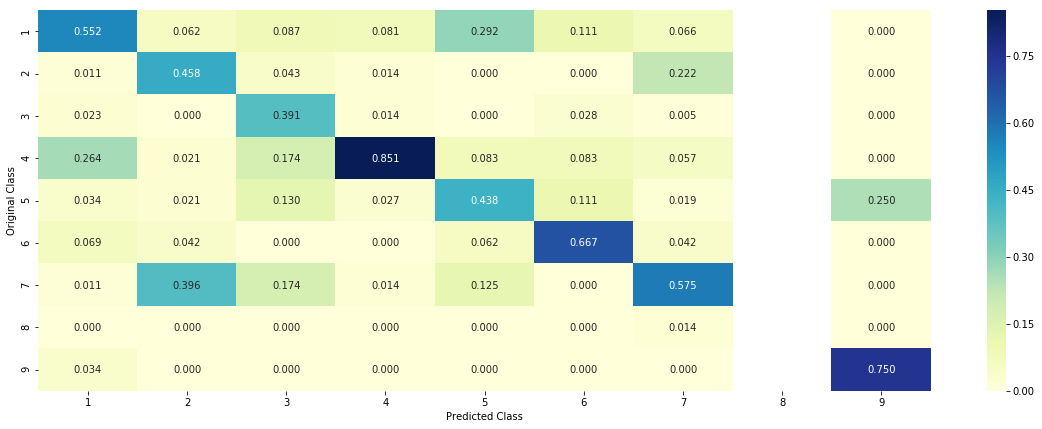

-------------------- Recall matrix (Row sum=1) --------------------


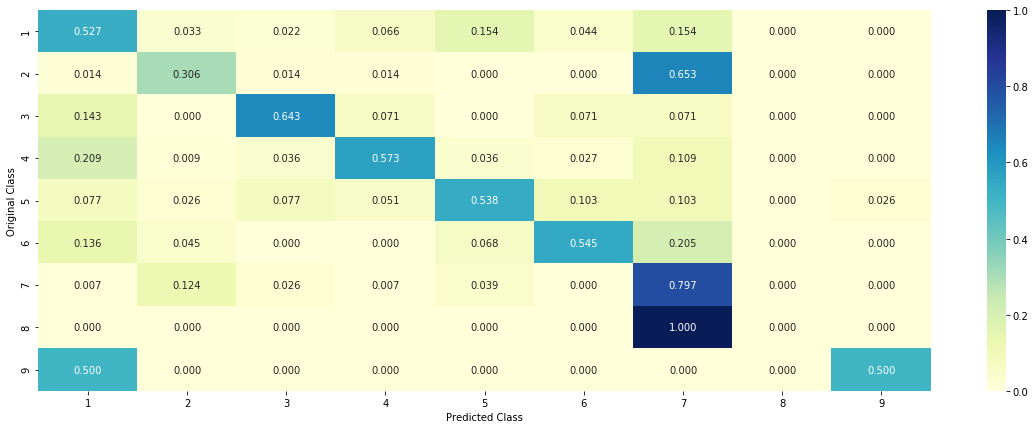

In [192]:
# testing the model with best hyperparameters
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Feature importance and interpretability for correctly classified point

In [195]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0937 0.5937 0.013  0.1204 0.0425 0.0346 0.0928 0.005  0.0044]]
Actual Class : 2
--------------------------------------------------
20 Text feature [clinical] present in test data point [True]
21 Text feature [sequencing] present in test data point [True]
22 Text feature [detection] present in test data point [True]
23 Text feature [achieved] present in test data point [True]
25 Text feature [patient] present in test data point [True]
26 Text feature [using] present in test data point [True]
27 Text feature [novel] present in test data point [True]
28 Text feature [another] present in test data point [True]
29 Text feature [15] present in test data point [True]
30 Text feature [including] present in test data point [True]
31 Text feature [molecular] present in test data point [True]
33 Text feature [present] present in test data point [True]
36 Text feature [mutations] present in test data point [True]
38 Text feature [12] present i

### Feature importance and interpretabilty of incorrectly unclassified class

In [196]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0837 0.077  0.0116 0.6674 0.038  0.0309 0.0829 0.0045 0.004 ]]
Actual Class : 1
--------------------------------------------------
10 Text feature [function] present in test data point [True]
13 Text feature [protein] present in test data point [True]
14 Text feature [missense] present in test data point [True]
15 Text feature [mammalian] present in test data point [True]
16 Text feature [functional] present in test data point [True]
17 Text feature [proteins] present in test data point [True]
20 Text feature [activity] present in test data point [True]
21 Text feature [acid] present in test data point [True]
22 Text feature [experiments] present in test data point [True]
23 Text feature [retained] present in test data point [True]
24 Text feature [results] present in test data point [True]
25 Text feature [amino] present in test data point [True]
26 Text feature [abrogate] present in test data point [True]
27 Text feature [ability

## 2. K- Nearest Neighbors Classification
### Hyper parameter tuning

for alpha = 5
Log Loss : 0.9642178962836317
for alpha = 11
Log Loss : 1.016712797429265
for alpha = 15
Log Loss : 1.0228853126231907
for alpha = 21
Log Loss : 1.0275270302823212
for alpha = 31
Log Loss : 1.0600953324563702
for alpha = 41
Log Loss : 1.0850201739915786
for alpha = 51
Log Loss : 1.0987321656143236
for alpha = 99
Log Loss : 1.1172643438189787


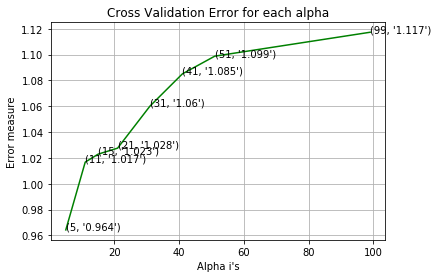

For values of best alpha =  5 The train log loss is: 0.6006346250445999
For values of best alpha =  5 The cross validation log loss is: 0.9642178962836317
For values of best alpha =  5 The test log loss is: 0.9148027403311335


In [197]:

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing the model with best hyperparameter

Log loss : 0.9642178962836317
Number of mis-classified points : 0.3082706766917293
-------------------- Confusion matrix --------------------


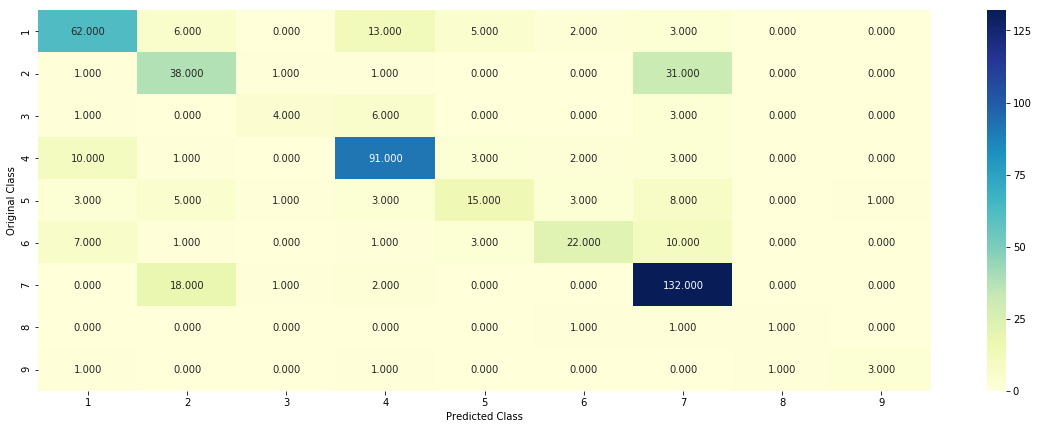

-------------------- Precision matrix (Columm Sum=1) --------------------


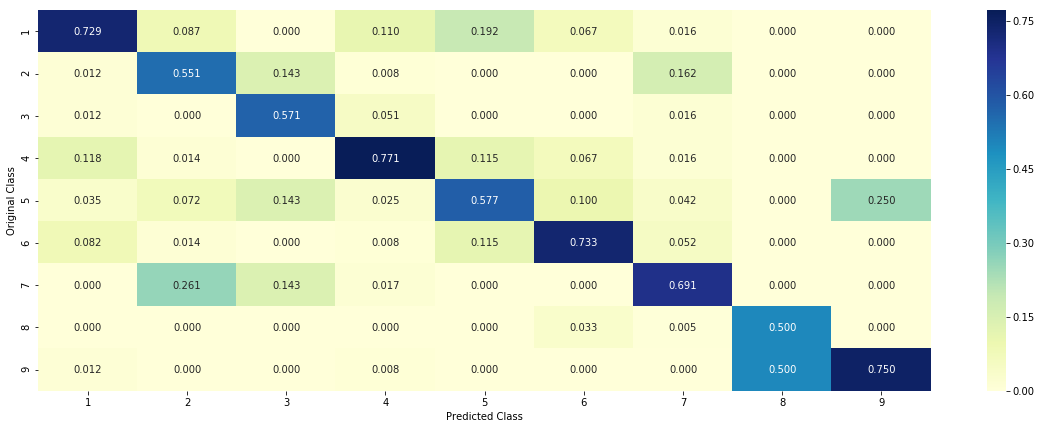

-------------------- Recall matrix (Row sum=1) --------------------


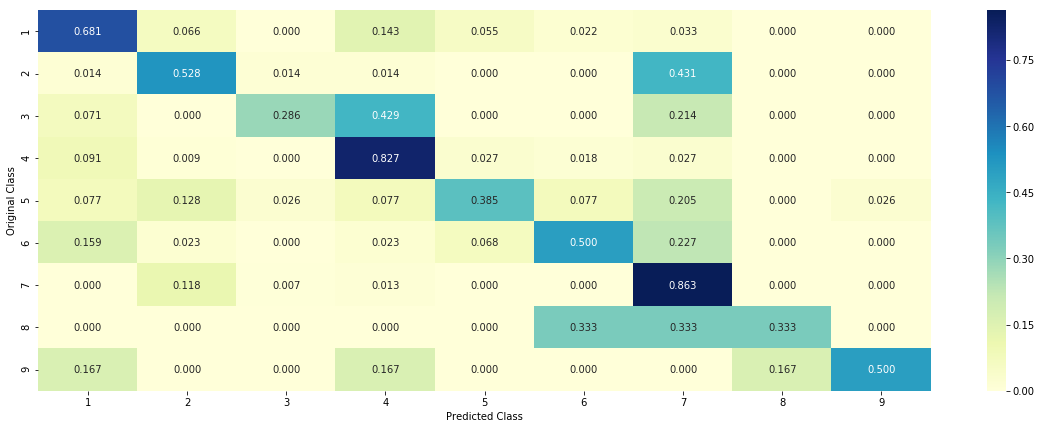

In [198]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

### Correctly classified point

In [199]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
The  5  nearest neighbours of the test points belongs to classes [1 1 1 1 1]
Fequency of nearest points : Counter({1: 5})


### Incorrectly Classified point

In [201]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 4

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 6
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [4 1 4 4 1]
Fequency of nearest points : Counter({4: 3, 1: 2})


## 3. Logistic Regression with class balancing

### Hyperparameter tuning

for alpha = 1e-06
Log Loss : 1.463663836535449
for alpha = 1e-05
Log Loss : 1.4545347483954116
for alpha = 0.0001
Log Loss : 1.422775448776759
for alpha = 0.001
Log Loss : 1.2694007569439907
for alpha = 0.01
Log Loss : 1.2985292174554708
for alpha = 0.1
Log Loss : 1.5276820790124908
for alpha = 1
Log Loss : 1.719322220548427
for alpha = 10
Log Loss : 1.7410778500083857
for alpha = 100
Log Loss : 1.7434317743216874


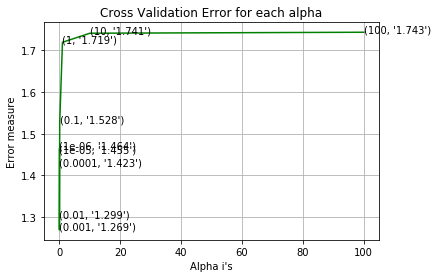

For values of best alpha =  0.001 The train log loss is: 0.5868141497867099
For values of best alpha =  0.001 The cross validation log loss is: 1.2694007569439907
For values of best alpha =  0.001 The test log loss is: 1.121981300828519


In [202]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing with best hyperparameters

Log loss : 1.2694007569439907
Number of mis-classified points : 0.40601503759398494
-------------------- Confusion matrix --------------------


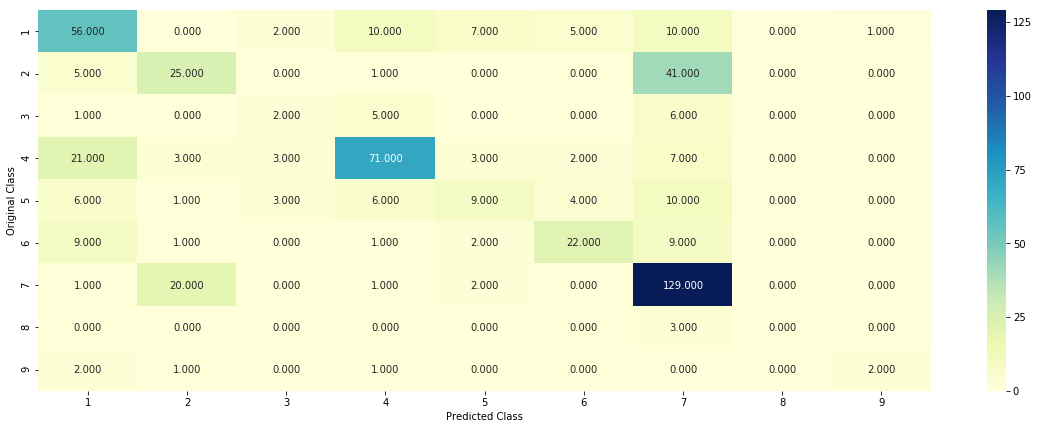

-------------------- Precision matrix (Columm Sum=1) --------------------


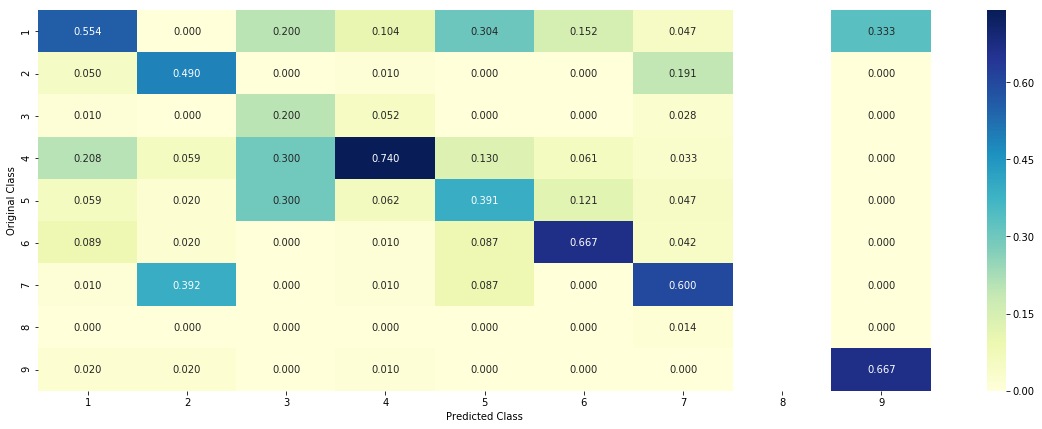

-------------------- Recall matrix (Row sum=1) --------------------


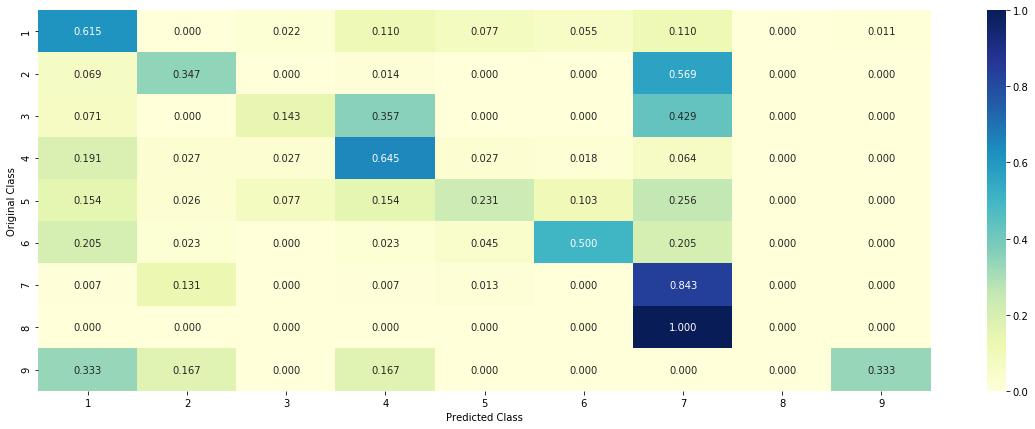

In [203]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [204]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

### Correctly Classified point

In [207]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.004  0.8677 0.0017 0.0038 0.0086 0.0033 0.0996 0.0055 0.0057]]
Actual Class : 2
--------------------------------------------------
140 Text feature [paradoxical] present in test data point [True]
248 Text feature [g466] present in test data point [True]
334 Text feature [g596] present in test data point [True]
338 Text feature [fusions] present in test data point [True]
442 Text feature [hcs] present in test data point [True]
Out of the top  500  features  5 are present in query point


### Incorrectly Classified point

In [206]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[2.740e-02 9.000e-04 1.000e-04 9.407e-01 9.000e-04 1.100e-02 2.500e-03
  9.600e-03 6.900e-03]]
Actual Class : 1
--------------------------------------------------
260 Text feature [2t] present in test data point [True]
291 Text feature [suppressor] present in test data point [True]
322 Text feature [unstable] present in test data point [True]
368 Text feature [mislocalized] present in test data point [True]
421 Text feature [microscopy] present in test data point [True]
Out of the top  500  features  5 are present in query point


### Logistic Regression without Class balancing

for alpha = 1e-06
Log Loss : 1.4159248509941538
for alpha = 1e-05
Log Loss : 1.3964906255962815
for alpha = 0.0001
Log Loss : 1.3867285617768867
for alpha = 0.001
Log Loss : 1.286687003670094
for alpha = 0.01
Log Loss : 1.336178733747232
for alpha = 0.1
Log Loss : 1.4160749957784464
for alpha = 1
Log Loss : 1.603800341108314


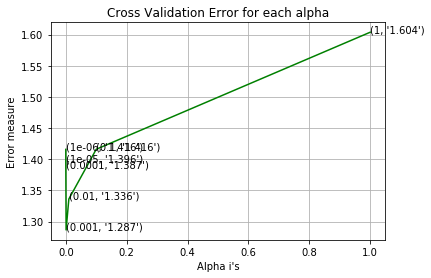

For values of best alpha =  0.001 The train log loss is: 0.5784374469690842
For values of best alpha =  0.001 The cross validation log loss is: 1.286687003670094
For values of best alpha =  0.001 The test log loss is: 1.1310322781325264


In [208]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.286687003670094
Number of mis-classified points : 0.40037593984962405
-------------------- Confusion matrix --------------------


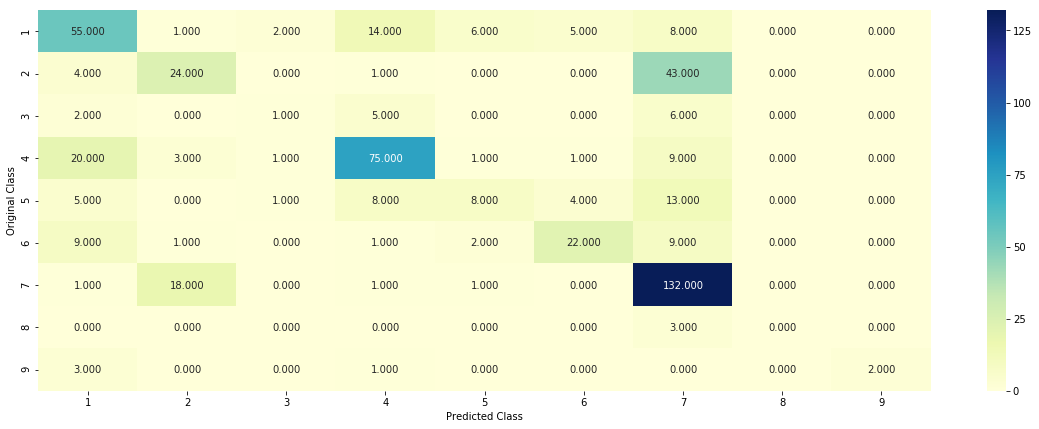

-------------------- Precision matrix (Columm Sum=1) --------------------


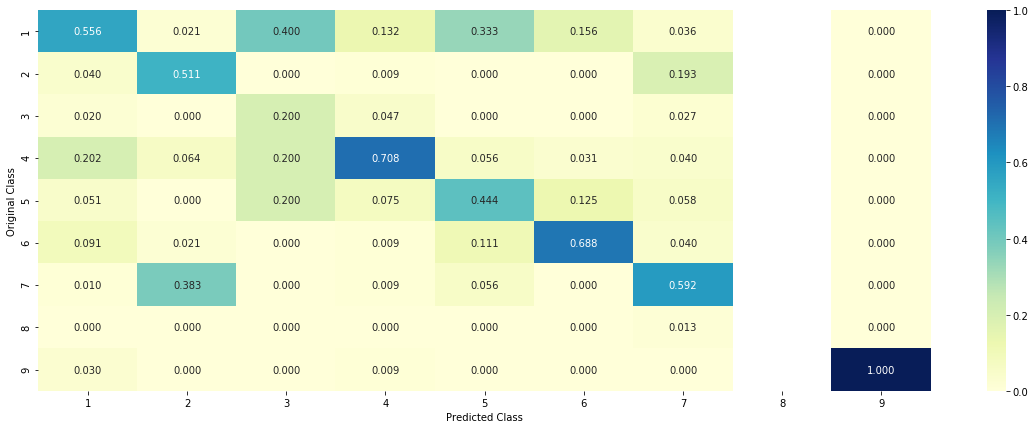

-------------------- Recall matrix (Row sum=1) --------------------


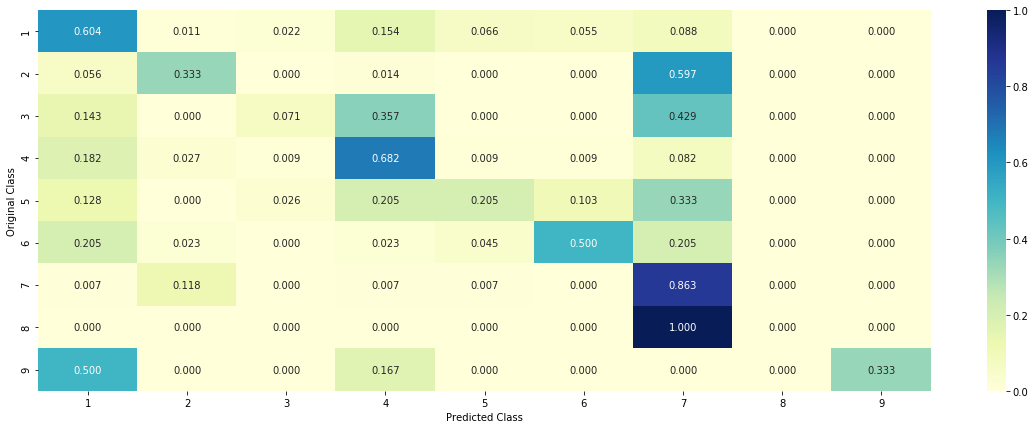

In [209]:
# testing model with best hyprparameter
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [210]:
### Feature importance for correctly classified point

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[4.500e-03 7.633e-01 8.000e-04 4.100e-03 6.300e-03 2.000e-03 2.156e-01
  2.700e-03 7.000e-04]]
Actual Class : 2
--------------------------------------------------
152 Text feature [paradoxical] present in test data point [True]
266 Text feature [g466] present in test data point [True]
345 Text feature [fusions] present in test data point [True]
359 Text feature [g596] present in test data point [True]
438 Text feature [hcs] present in test data point [True]
460 Text feature [craf] present in test data point [True]
Out of the top  500  features  6 are present in query point


In [211]:
### Feature importance for incorrectly classified point

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[3.990e-02 1.400e-03 0.000e+00 9.408e-01 5.000e-04 7.000e-03 6.600e-03
  3.800e-03 1.000e-04]]
Actual Class : 1
--------------------------------------------------
269 Text feature [2t] present in test data point [True]
356 Text feature [suppressor] present in test data point [True]
444 Text feature [unstable] present in test data point [True]
Out of the top  500  features  3 are present in query point


### Linear Support Vector Machine

for C = 1e-05
Log Loss : 1.4765597567196311
for C = 0.0001
Log Loss : 1.4505147316258908
for C = 0.001
Log Loss : 1.362379893659571
for C = 0.01
Log Loss : 1.2338427964721876
for C = 0.1
Log Loss : 1.466526290511817
for C = 1
Log Loss : 1.7322046471272494
for C = 10
Log Loss : 1.743907266752057
for C = 100
Log Loss : 1.7439071353387048


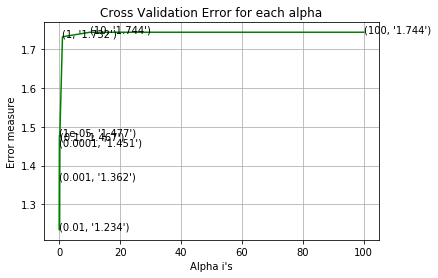

For values of best alpha =  0.01 The train log loss is: 0.7049433821044965
For values of best alpha =  0.01 The cross validation log loss is: 1.2338427964721876
For values of best alpha =  0.01 The test log loss is: 1.1971814758719035


In [212]:

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing the model with best hyperparameters

Log loss : 1.2338427964721876
Number of mis-classified points : 0.39285714285714285
-------------------- Confusion matrix --------------------


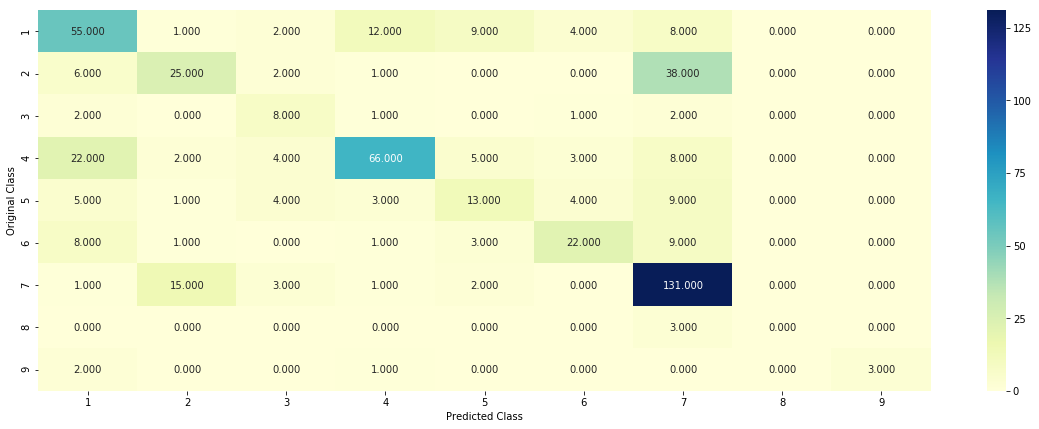

-------------------- Precision matrix (Columm Sum=1) --------------------


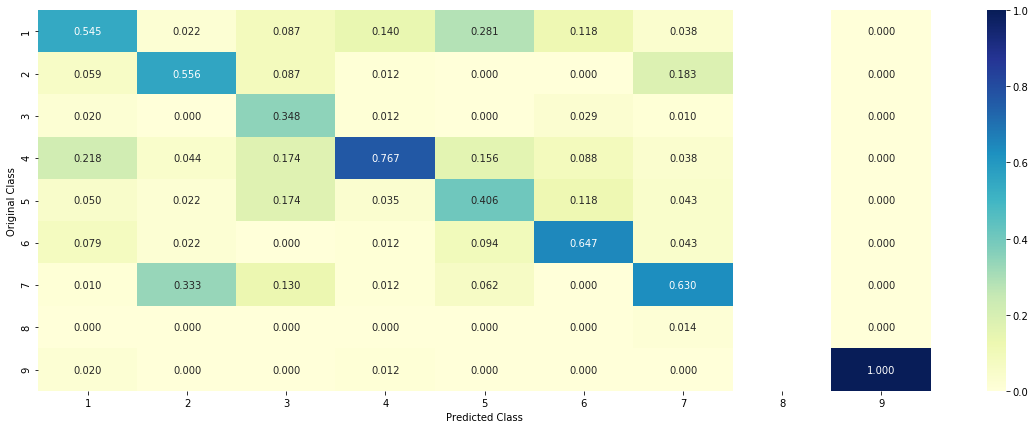

-------------------- Recall matrix (Row sum=1) --------------------


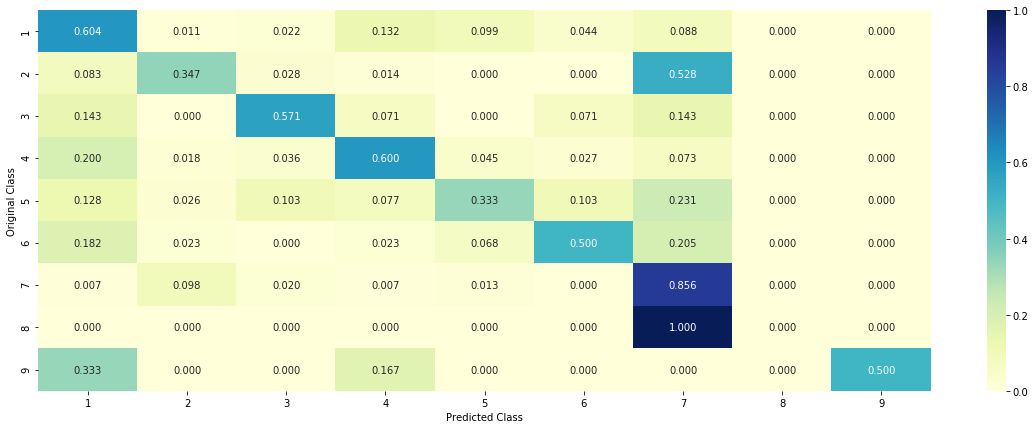

In [225]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [226]:
# Feature importance for correctly classified point
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 2
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0299 0.8881 0.0067 0.0359 0.013  0.0042 0.0146 0.0042 0.0034]]
Actual Class : 2
--------------------------------------------------
82 Text feature [g466] present in test data point [True]
124 Text feature [achieved] present in test data point [True]
133 Text feature [d594v] present in test data point [True]
144 Text feature [discov] present in test data point [True]
185 Text feature [2345] present in test data point [True]
186 Text feature [g596] present in test data point [True]
187 Text feature [brafr509h] present in test data point [True]
188 Text feature [brafe586k] present in test data point [True]
218 Text feature [hcs] present in test data point [True]
250 Text feature [colors] present in test data point [True]
255 Text feature [g464] present in test data point [True]
307 Text feature [paradoxical] present in test data point [True]
386 Text feature [benefi] present in test data point [True]
428 Text feature [craf] present in

In [229]:
# Feature importance for incorrectly classified point
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[1.051e-01 2.200e-03 7.000e-04 8.269e-01 3.900e-03 3.690e-02 1.860e-02
  4.300e-03 1.400e-03]]
Actual Class : 1
--------------------------------------------------
48 Text feature [mislocalized] present in test data point [True]
51 Text feature [2t] present in test data point [True]
109 Text feature [microscopy] present in test data point [True]
116 Text feature [mislocalization] present in test data point [True]
129 Text feature [h83y] present in test data point [True]
141 Text feature [suppressor] present in test data point [True]
155 Text feature [unstable] present in test data point [True]
295 Text feature [ankyrin] present in test data point [True]
346 Text feature [stability] present in test data point [True]
377 Text feature [kaufman] present in test data point [True]
435 Text feature [nonfunctional] present in test data point [True]
453 Text feature [subcellular] present in test data point [True]
Out of the top  500  features  

## Random Forrest Classifier
### Hyperparameter tuning (one hot encoding)

In [231]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2850283054030813
for n_estimators = 100 and max depth =  10
Log Loss : 1.2046166245141225
for n_estimators = 200 and max depth =  5
Log Loss : 1.2697890876499087
for n_estimators = 200 and max depth =  10
Log Loss : 1.2004943329283213
for n_estimators = 500 and max depth =  5
Log Loss : 1.2652380733107804
for n_estimators = 500 and max depth =  10
Log Loss : 1.1973231802516857
for n_estimators = 1000 and max depth =  5
Log Loss : 1.259232904016264
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1965139077056222
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2625940618808769
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1974748819329688
For values of best estimator =  1000 The train log loss is: 0.6958891995209167
For values of best estimator =  1000 The cross validation log loss is: 1.1965139077056222
For values of best estimator =  1000 The test log loss is: 1.1686524196819386


Log loss : 1.196513907705622
Number of mis-classified points : 0.3966165413533835
-------------------- Confusion matrix --------------------


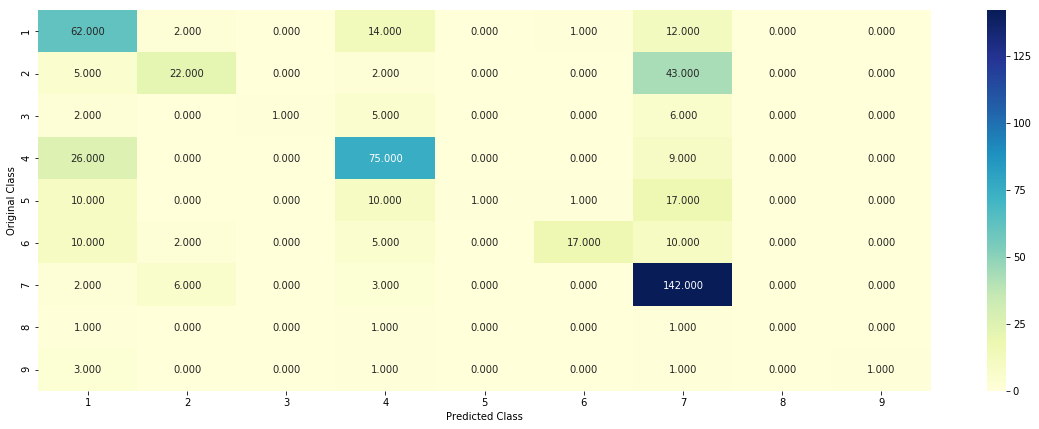

-------------------- Precision matrix (Columm Sum=1) --------------------


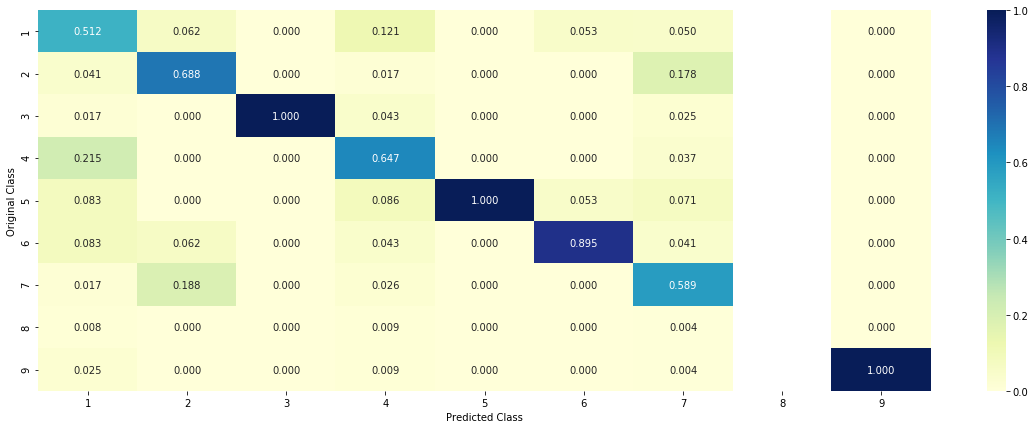

-------------------- Recall matrix (Row sum=1) --------------------


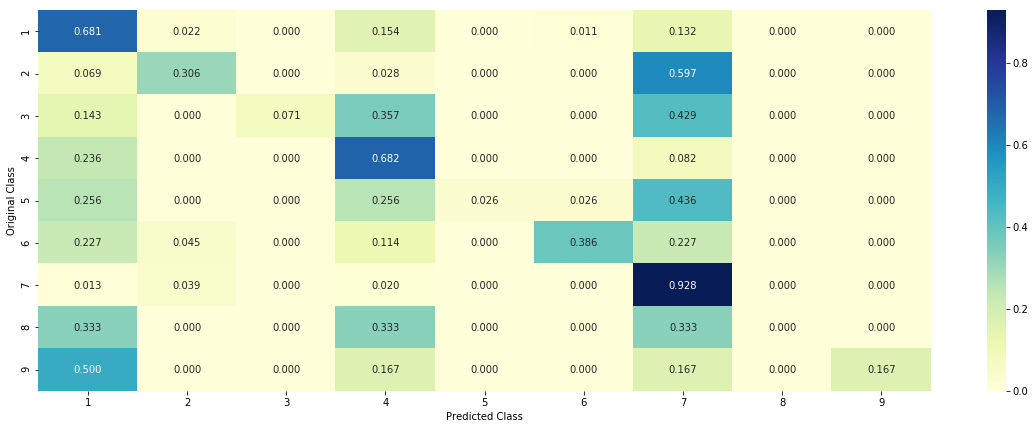

In [232]:
# testing the model with best hyperparameter
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [233]:

### Hyperparameter with responsecoding

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 0.9500622588129184
for n_estimators = 10 and max depth =  3
Log Loss : 0.8791501976952855
for n_estimators = 10 and max depth =  5
Log Loss : 0.5739485223948549
for n_estimators = 10 and max depth =  10
Log Loss : 0.5221215488409784
for n_estimators = 50 and max depth =  2
Log Loss : 0.770951314333186
for n_estimators = 50 and max depth =  3
Log Loss : 0.6708979428778136
for n_estimators = 50 and max depth =  5
Log Loss : 0.50915090255249
for n_estimators = 50 and max depth =  10
Log Loss : 0.4769632160508903
for n_estimators = 100 and max depth =  2
Log Loss : 0.7571413024978197
for n_estimators = 100 and max depth =  3
Log Loss : 0.6372436396378427
for n_estimators = 100 and max depth =  5
Log Loss : 0.49898616857541356
for n_estimators = 100 and max depth =  10
Log Loss : 0.47650306904000744
for n_estimators = 200 and max depth =  2
Log Loss : 0.7389961429478618
for n_estimators = 200 and max depth =  3
Log Loss : 0.628002670766632

In [250]:
# Testing model with best hyperparameter(responsecoding)

#clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators= alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)

predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)


In [237]:
# feature importance for correctly classified point
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 2
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0104 0.9394 0.0048 0.0103 0.0122 0.0091 0.0089 0.0018 0.0031]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


In [238]:
#feature importance for incorrectly classified point
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.9162 0.0136 0.0066 0.0241 0.0136 0.0123 0.0081 0.002  0.0034]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## Stack the models

In [241]:
from mlxtend.classifier import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.26
Support vector machines : Log Loss: 1.73
Naive Bayes : Log Loss: 1.34
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.040
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.546
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.225
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.373
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.674


In [242]:
# testing the model with best hyperparametrs

Log loss (train) on the stacking classifier : 0.6426757854467049
Log loss (CV) on the stacking classifier : 1.2251630176325856
Log loss (test) on the stacking classifier : 1.1568684692621891
Number of missclassified point : 0.37894736842105264
-------------------- Confusion matrix --------------------


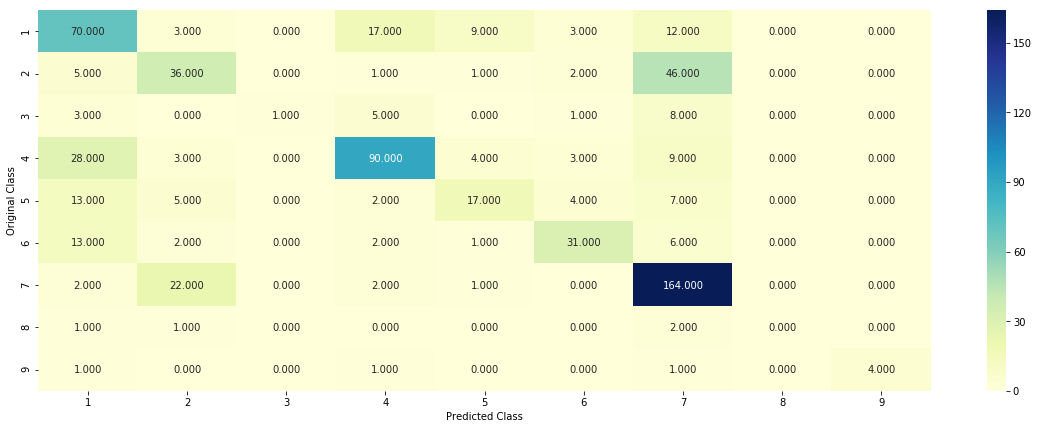

-------------------- Precision matrix (Columm Sum=1) --------------------


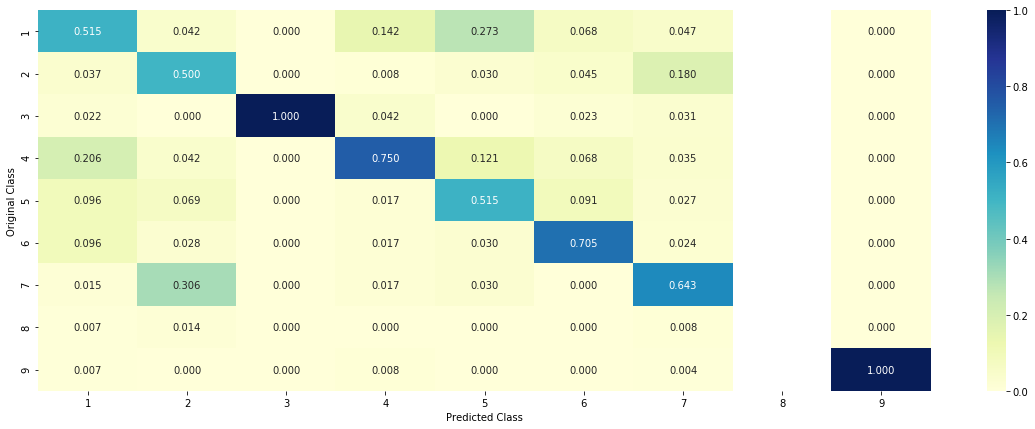

-------------------- Recall matrix (Row sum=1) --------------------


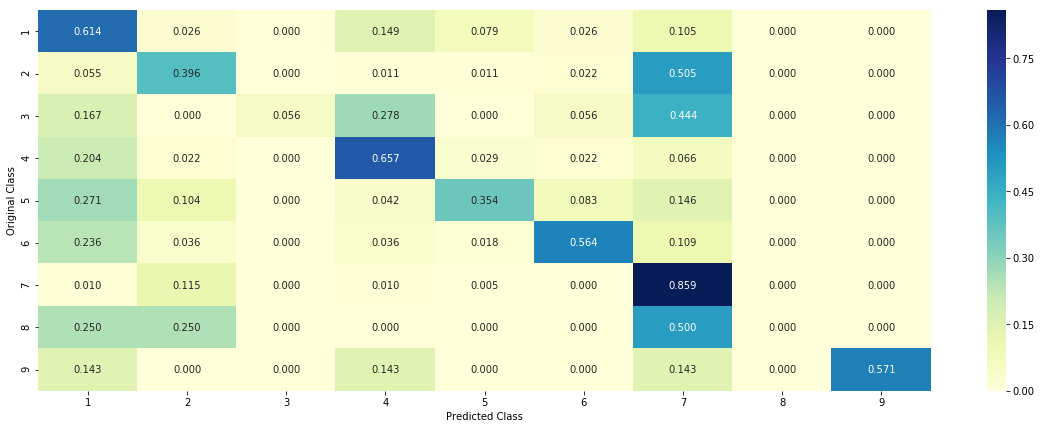

In [243]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Majority Voting Classifier

Log loss (train) on the VotingClassifier : 0.8855971705026485
Log loss (CV) on the VotingClassifier : 1.2721597295965146
Log loss (test) on the VotingClassifier : 1.2263966563720579
Number of missclassified point : 0.3804511278195489
-------------------- Confusion matrix --------------------


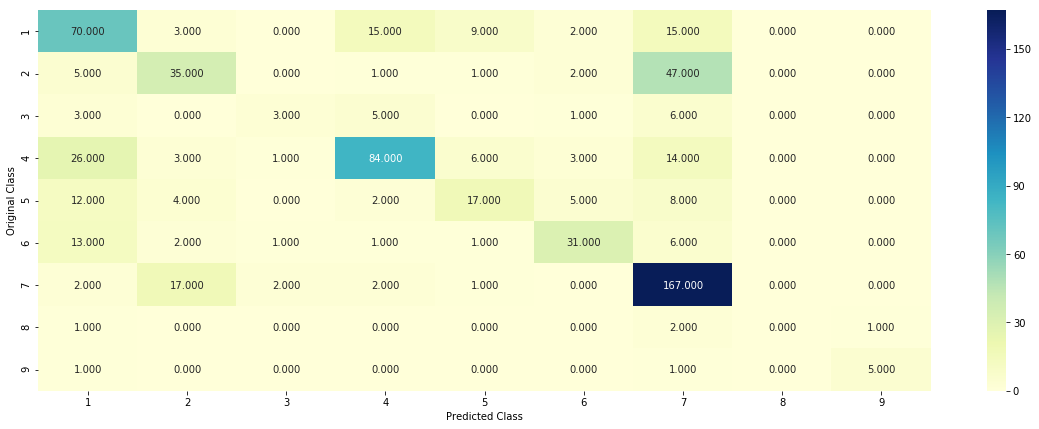

-------------------- Precision matrix (Columm Sum=1) --------------------


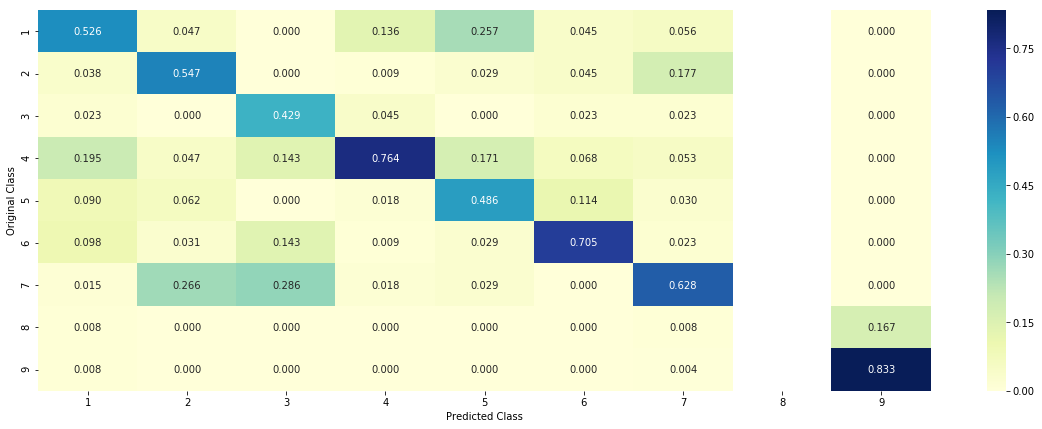

-------------------- Recall matrix (Row sum=1) --------------------


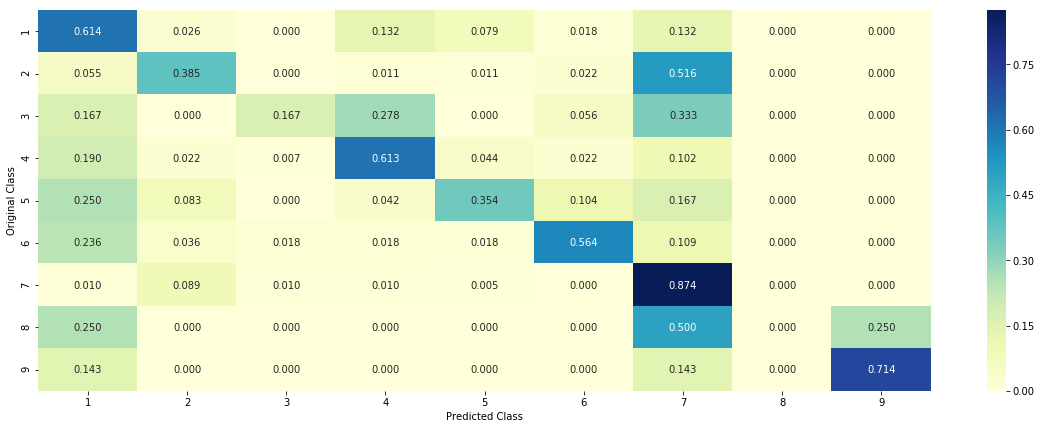

In [244]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

## Conclusion



In [249]:
print()
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = "*** Model Summary *** [Performance Metric: Log-Loss]"
ptable.field_names=["Model Name","Train","CV","Test","% Misclassified Points"]
ptable.add_row(["Naive Bayes","0.81","1.33","1.32","41"])
ptable.add_row(["KNN","0.60","0.96","0.91","30"])
ptable.add_row(["Logistic Regression With Class balancing","0.58","1.26","1.21","40"])
ptable.add_row(["Logistic Regression Without Class balancing","0.57","1.286","1.11","40"])
ptable.add_row(["Linear SVM","0.70","1.23","1.197","39"])
ptable.add_row(["Random Forest Classifier With One hot Encoding","0.70","1.23","1.197","39"])
ptable.add_row(["Stack Models:LR+NB+SVM","0.64","1.22","1.56","37"])
ptable.add_row(["Maximum Voting classifier","0.88","1.22","1.22","38"])
print(ptable)
print()


+------------------------------------------------+-------+-------+-------+------------------------+
|                   Model Name                   | Train |   CV  |  Test | % Misclassified Points |
+------------------------------------------------+-------+-------+-------+------------------------+
|                  Naive Bayes                   |  0.81 |  1.33 |  1.32 |           41           |
|                      KNN                       |  0.60 |  0.96 |  0.91 |           30           |
|    Logistic Regression With Class balancing    |  0.58 |  1.26 |  1.21 |           40           |
|  Logistic Regression Without Class balancing   |  0.57 | 1.286 |  1.11 |           40           |
|                   Linear SVM                   |  0.70 |  1.23 | 1.197 |           39           |
| Random Forest Classifier With One hot Encoding |  0.70 |  1.23 | 1.197 |           39           |
|             Stack Models:LR+NB+SVM             |  0.64 |  1.22 |  1.56 |           37           |